In [33]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import catboost as cat
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

color_pal = sns.color_palette()

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [3]:
test_data = pd.read_parquet(Path("data") / "test.parquet")

In [4]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


In [5]:
data["date"] = pd.to_datetime(data["date"])

In [6]:
data = data.set_index("date")

In [7]:
test_data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
56474,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2021-08-10 05:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
56477,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.098612
56480,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2021-08-10 07:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
56483,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2021-08-10 09:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
56486,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2021-08-10 10:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147


In [8]:
test_data["date"] = pd.to_datetime(test_data["date"])
test_data = test_data.set_index("date")

In [9]:
train = data[["counter_name", "log_bike_count"]]
test = test_data[["counter_name", "log_bike_count"]]

In [10]:
# train.drop("counter_name", axis=1, inplace=True)

In [11]:
# test.drop("counter_name", axis=1, inplace=True)

In [12]:
train.head()

,counter_name,log_bike_count
date,,
2020-09-01 02:00:00,28 boulevard Diderot E-O,0.000000
2020-09-01 03:00:00,28 boulevard Diderot E-O,0.693147
2020-09-01 04:00:00,28 boulevard Diderot E-O,0.000000
2020-09-01 15:00:00,28 boulevard Diderot E-O,1.609438
2020-09-01 18:00:00,28 boulevard Diderot E-O,2.302585


In [13]:
test.head()

,counter_name,log_bike_count
date,,
2021-08-10 05:00:00,28 boulevard Diderot E-O,0.693147
2021-08-10 06:00:00,28 boulevard Diderot E-O,1.098612
2021-08-10 07:00:00,28 boulevard Diderot E-O,0.693147
2021-08-10 09:00:00,28 boulevard Diderot E-O,0.000000
2021-08-10 10:00:00,28 boulevard Diderot E-O,0.693147


In [14]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

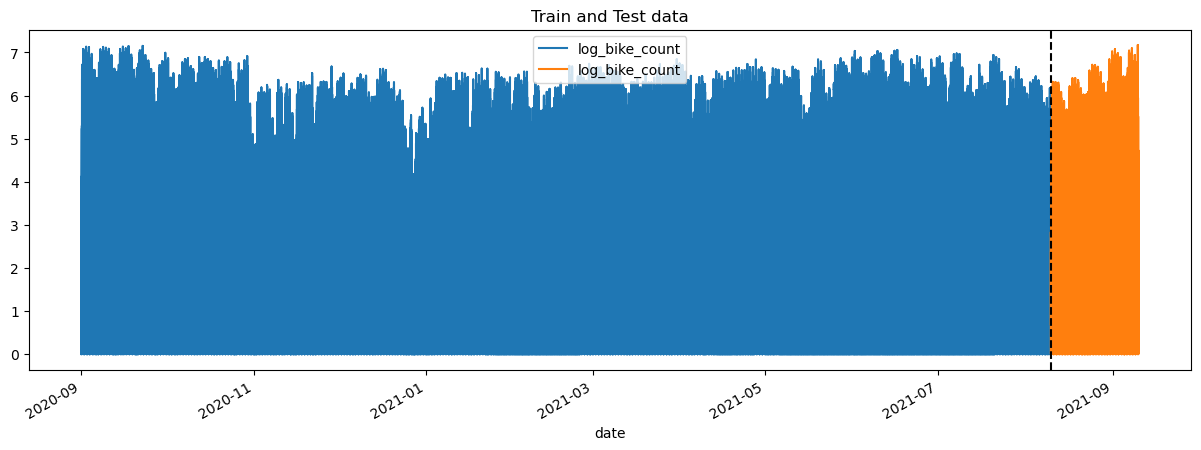

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training Set", title="Train and Test data")
test.plot(ax=ax, label="Testing Set")
ax.axvline("2021-08-10 02:00:00", color="black", ls="--")
ax.legend
plt.show()

<AxesSubplot: xlabel='date'>

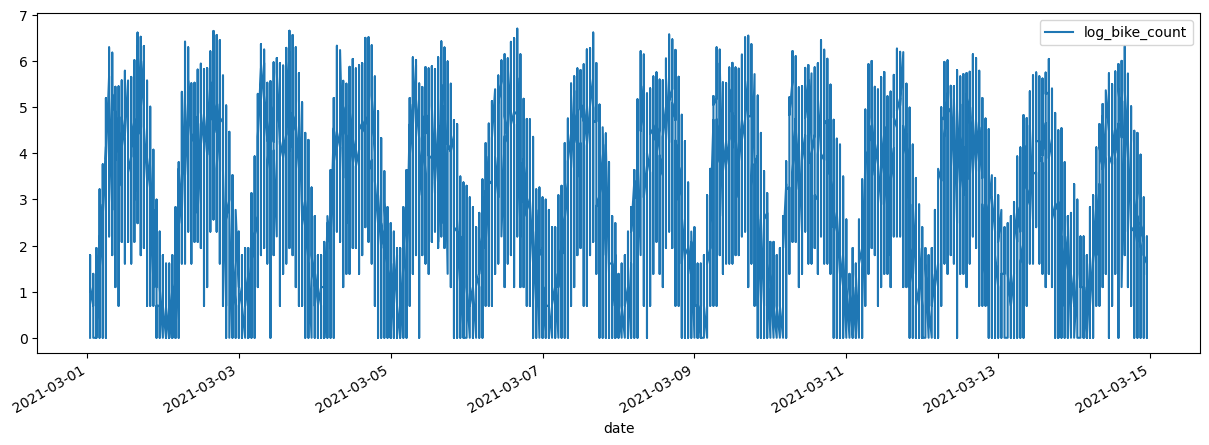

In [16]:
train.loc[(train.index > "2021-03-01") & (train.index < "2021-03-15")].plot(
    figsize=(15, 5)
)

<AxesSubplot: xlabel='date'>

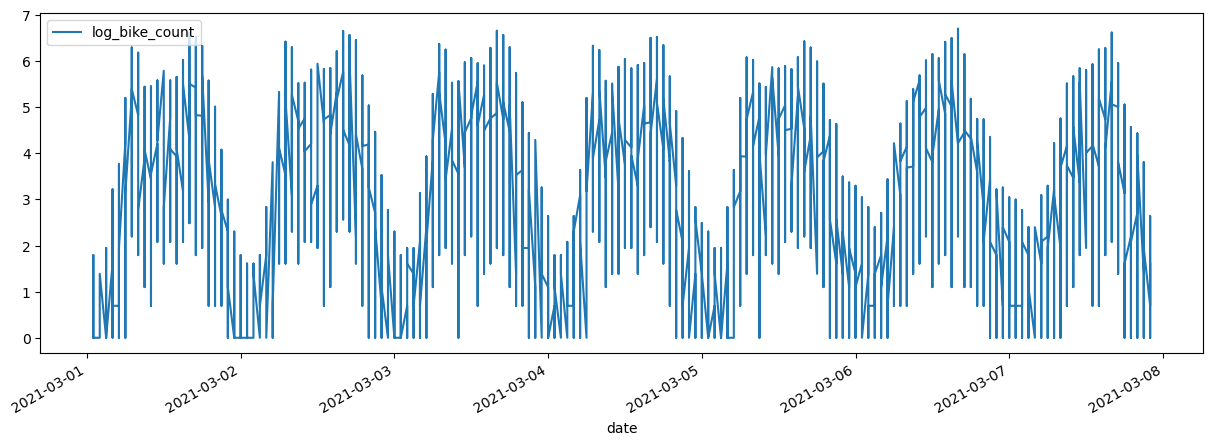

In [17]:
train.loc[
    (train.index > "2021-03-01 00:00:00") & (train.index < "2021-03-07 23:00:00")
].plot(figsize=(15, 5))

In [18]:
# Feature creation
def create_features(train):
    """
    Create time series features based on timeseries index
    """
    train["hour"] = train.index.hour
    train["dayofweek"] = train.index.dayofweek
    train["quarter"] = train.index.quarter
    train["month"] = train.index.month
    train["dayofyear"] = train.index.dayofyear
    return train

In [19]:
data = create_features(data)

In [20]:
train = create_features(train)
test = create_features(test)

C:\Users\ameya\AppData\Local\Temp\ipykernel_3472\1206218847.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["hour"] = train.index.hour
C:\Users\ameya\AppData\Local\Temp\ipykernel_3472\1206218847.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["dayofweek"] = train.index.dayofweek
C:\Users\ameya\AppData\Local\Temp\ipykernel_3472\1206218847.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [21]:
train.head()

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear
date,,,,,,,
2020-09-01 02:00:00,28 boulevard Diderot E-O,0.000000,2,1,3,9,245
2020-09-01 03:00:00,28 boulevard Diderot E-O,0.693147,3,1,3,9,245
2020-09-01 04:00:00,28 boulevard Diderot E-O,0.000000,4,1,3,9,245
2020-09-01 15:00:00,28 boulevard Diderot E-O,1.609438,15,1,3,9,245
2020-09-01 18:00:00,28 boulevard Diderot E-O,2.302585,18,1,3,9,245


In [22]:
test.head()

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear
date,,,,,,,
2021-08-10 05:00:00,28 boulevard Diderot E-O,0.693147,5,1,3,8,222
2021-08-10 06:00:00,28 boulevard Diderot E-O,1.098612,6,1,3,8,222
2021-08-10 07:00:00,28 boulevard Diderot E-O,0.693147,7,1,3,8,222
2021-08-10 09:00:00,28 boulevard Diderot E-O,0.000000,9,1,3,8,222
2021-08-10 10:00:00,28 boulevard Diderot E-O,0.693147,10,1,3,8,222


Visualize our Feature/Target Relationship

Text(0.5, 1.0, 'Bike Counts by Hour')

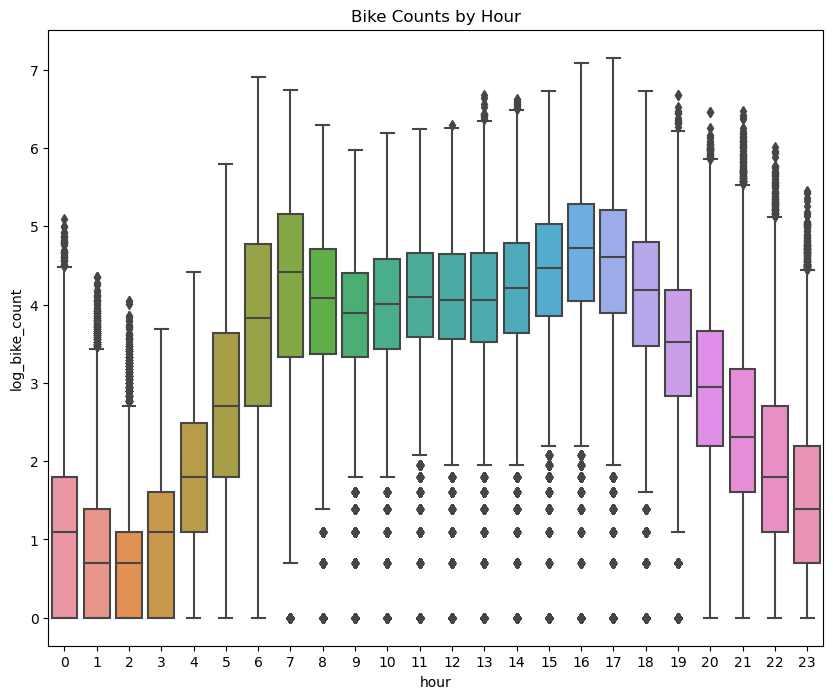

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=train, x="hour", y="log_bike_count")
ax.set_title("Bike Counts by Hour")

Text(0.5, 1.0, 'Test Bike Counts by Hour')

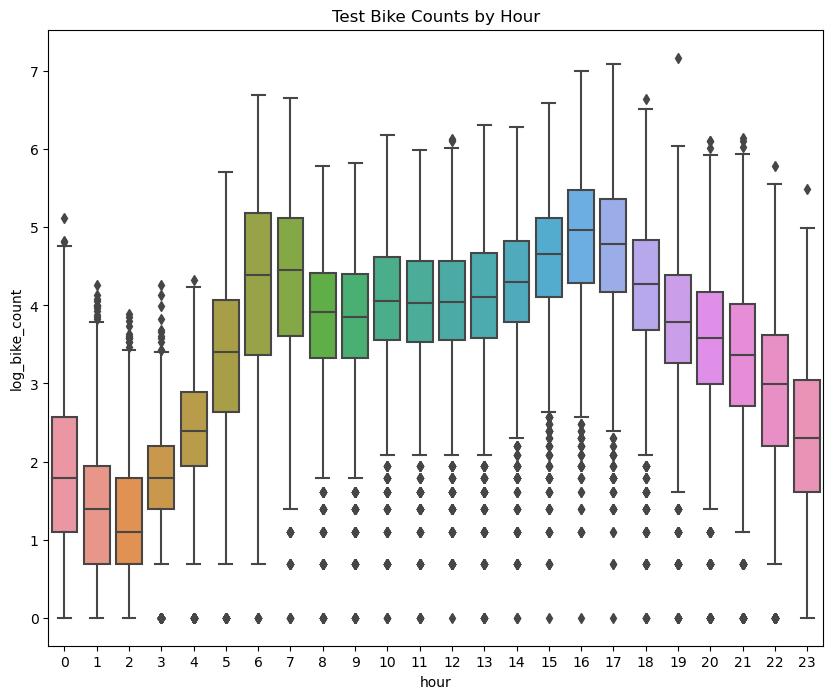

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=test, x="hour", y="log_bike_count")
ax.set_title("Test Bike Counts by Hour")

Text(0.5, 1.0, 'Bike Counts by Months')

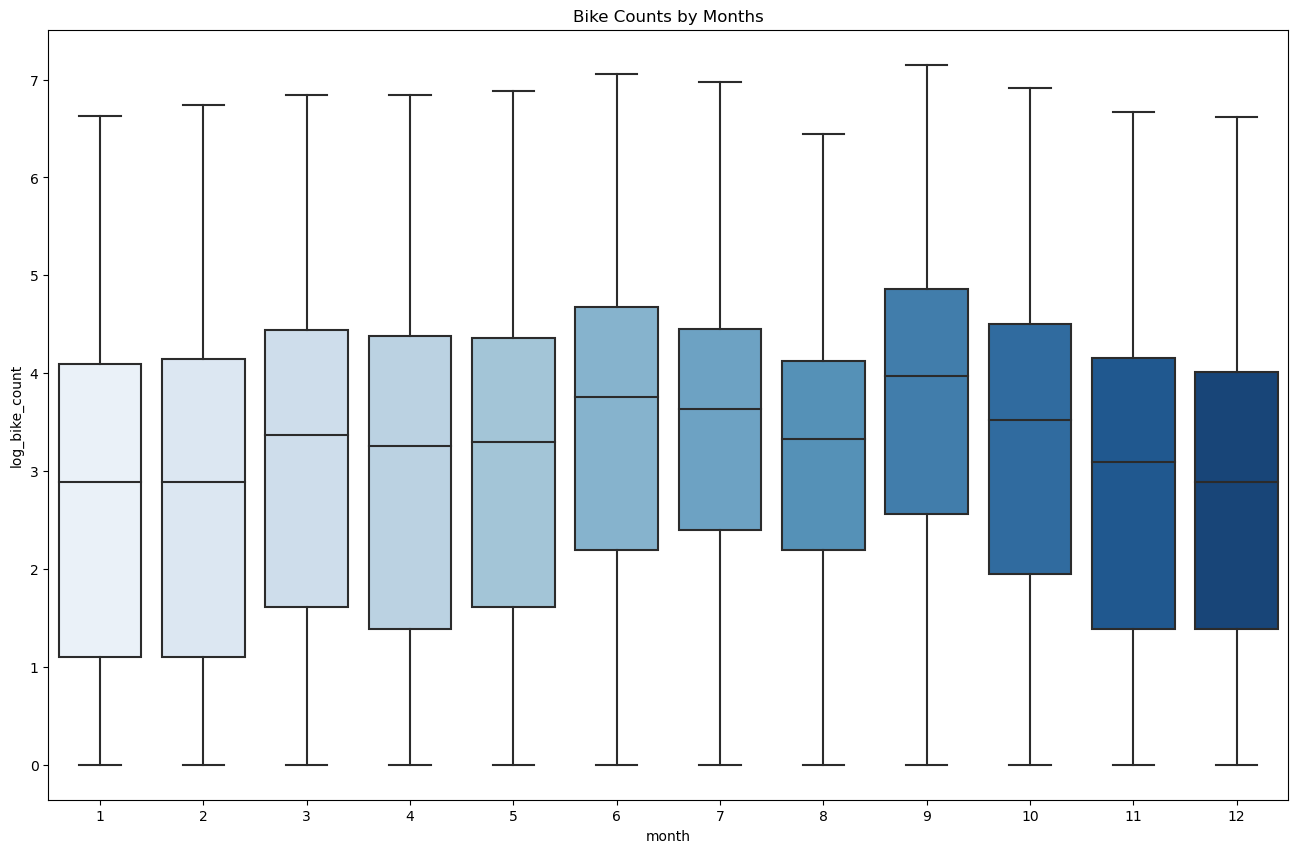

In [25]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(data=train, x="month", y="log_bike_count", palette="Blues")
ax.set_title("Bike Counts by Months")

Text(0.5, 1.0, 'Test Bike Counts by Months')

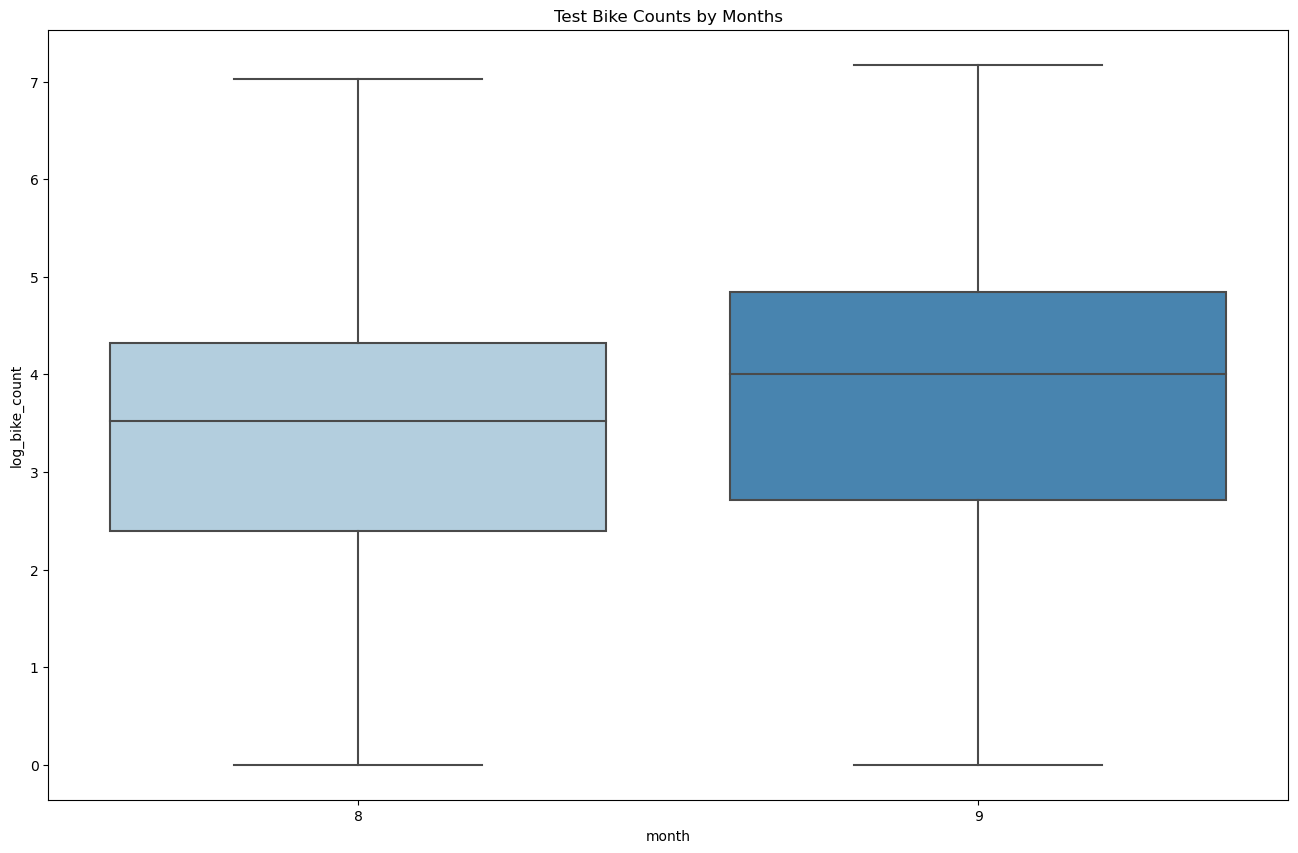

In [26]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(data=test, x="month", y="log_bike_count", palette="Blues")
ax.set_title("Test Bike Counts by Months")

Create our Model

In [27]:
features = ["counter_name", "hour", "dayofweek", "quarter", "month", "dayofyear"]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [28]:
reg = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, enable_categorical=True)

In [52]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000)

In [30]:
train.columns

Index(['counter_name', 'log_bike_count', 'hour', 'dayofweek', 'quarter',
       'month', 'dayofyear'],
      dtype='object')

In [31]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [34]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [35]:
preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, cat_feature)],
    remainder="passthrough",
)

In [36]:
base_estimator = DecisionTreeRegressor()

In [37]:
ada_boost_model = AdaBoostRegressor(
    base_estimator=base_estimator, n_estimators=100, random_state=42
)

In [45]:
xgb_model = xgb.XGBRegressor()

In [53]:
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", cat_reg)])

In [54]:
pipeline.fit(X_train, y_train.values.ravel())

Learning rate set to 0.107689
0:	learn: 1.5705254	total: 102ms	remaining: 1m 42s
1:	learn: 1.4811681	total: 127ms	remaining: 1m 3s
2:	learn: 1.4051769	total: 146ms	remaining: 48.4s
3:	learn: 1.3402127	total: 163ms	remaining: 40.6s
4:	learn: 1.2843398	total: 181ms	remaining: 36s
5:	learn: 1.2351455	total: 200ms	remaining: 33.1s
6:	learn: 1.1923497	total: 217ms	remaining: 30.8s
7:	learn: 1.1557438	total: 234ms	remaining: 29.1s
8:	learn: 1.1244338	total: 251ms	remaining: 27.6s
9:	learn: 1.0921527	total: 269ms	remaining: 26.6s
10:	learn: 1.0684732	total: 286ms	remaining: 25.7s
11:	learn: 1.0472620	total: 302ms	remaining: 24.9s
12:	learn: 1.0280577	total: 319ms	remaining: 24.2s
13:	learn: 1.0086546	total: 336ms	remaining: 23.7s
14:	learn: 0.9945035	total: 352ms	remaining: 23.1s
15:	learn: 0.9799154	total: 372ms	remaining: 22.9s
16:	learn: 0.9680164	total: 389ms	remaining: 22.5s
17:	learn: 0.9574902	total: 408ms	remaining: 22.3s
18:	learn: 0.9475875	total: 426ms	remaining: 22s
19:	learn: 0.9

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name'])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x000001B8EBA63370>)])

In [55]:
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.408353864558275


In [32]:
reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21629	validation_1-rmse:2.38004


c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.59089	validation_1-rmse:0.53951
[20]	validation_0-rmse:0.48307	validation_1-rmse:0.46495
[30]	validation_0-rmse:0.44602	validation_1-rmse:0.43738
[40]	validation_0-rmse:0.42394	validation_1-rmse:0.43561
[50]	validation_0-rmse:0.41137	validation_1-rmse:0.42909
[60]	validation_0-rmse:0.40258	validation_1-rmse:0.42597
[70]	validation_0-rmse:0.39334	validation_1-rmse:0.42457
[80]	validation_0-rmse:0.38684	validation_1-rmse:0.42290
[90]	validation_0-rmse:0.38151	validation_1-rmse:0.41752
[100]	validation_0-rmse:0.37517	validation_1-rmse:0.41615
[110]	validation_0-rmse:0.37158	validation_1-rmse:0.41526
[120]	validation_0-rmse:0.36781	validation_1-rmse:0.41448
[130]	validation_0-rmse:0.36427	validation_1-rmse:0.41432
[140]	validation_0-rmse:0.36117	validation_1-rmse:0.41349
[150]	validation_0-rmse:0.35805	validation_1-rmse:0.41245
[160]	validation_0-rmse:0.35556	validation_1-rmse:0.41178
[170]	validation_0-rmse:0.35280	validation_1-rmse:0.41163
[180]	validation_0-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [33]:
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

Learning rate set to 0.133115
0:	learn: 1.5285781	test: 1.5283890	test1: 1.3457365	best: 1.3457365 (0)	total: 323ms	remaining: 5m 22s
10:	learn: 0.9061010	test: 0.9041412	test1: 0.7821185	best: 0.7821185 (10)	total: 1.34s	remaining: 2m
20:	learn: 0.7797993	test: 0.7768433	test1: 0.6806251	best: 0.6806251 (20)	total: 2.48s	remaining: 1m 55s
30:	learn: 0.7373574	test: 0.7341106	test1: 0.6319129	best: 0.6319129 (30)	total: 3.67s	remaining: 1m 54s
40:	learn: 0.7111332	test: 0.7074448	test1: 0.6100430	best: 0.6100430 (40)	total: 4.92s	remaining: 1m 55s
50:	learn: 0.6949541	test: 0.6911342	test1: 0.5920938	best: 0.5920938 (50)	total: 6.18s	remaining: 1m 55s
60:	learn: 0.6609359	test: 0.6571133	test1: 0.5865411	best: 0.5865411 (60)	total: 7.48s	remaining: 1m 55s
70:	learn: 0.6364383	test: 0.6322085	test1: 0.5584359	best: 0.5584359 (70)	total: 8.73s	remaining: 1m 54s
80:	learn: 0.6247673	test: 0.6202571	test1: 0.5514453	best: 0.5514453 (80)	total: 9.98s	remaining: 1m 53s
90:	learn: 0.6148611	t

In [32]:
ada_reg.fit(X_train, y_train)

c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: could not convert string to float: '254 rue de Vaugirard NE-SO'

In [34]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

XGB Train: 0.3425510276525049
CAT Train: 0.4391494846860724


In [35]:
y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

XGB Test: 0.4075440751933483
CAT Test: 0.4275895804067583


In [ ]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

In [ ]:
fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

# Forecast on Test

In [ ]:
test["prediction"] = reg.predict(X_test)

In [ ]:
ax = test[["log_bike_count"]].plot()
test["prediction"].plot(ax=ax)
plt.legend()
ax.set_title("Raw Data vs Predictions")
plt.show()

In [ ]:
test.loc[(test.index > "2021-08-7") & (test.index < "2021-08-14")][
    "log_bike_count"
].plot(figsize=(15, 5))
test.loc[(test.index > "2021-08-7") & (test.index < "2021-08-14")]["prediction"].plot(
    figsize=(15, 5)
)

In [ ]:
rmse_test = mean_squared_error(
    test["log_bike_count"], test["prediction"], squared=False
)
print(rmse_test)

In [ ]:
test

In [ ]:
test["error"] = np.abs(test["log_bike_count"] - test["prediction"])

In [ ]:
test["error"]

In [ ]:
test["Date"] = test.index.date

In [ ]:
test.groupby("Date")["error"].mean().sort_values(ascending=True).head(5)

# Hyperparameter tuning and cross validation

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
param_grid = {
    "n_estimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_child_weight": [1, 2, 3],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
}

In [ ]:
grid_search = GridSearchCV(
    estimator=reg, param_grid=param_grid, cv=tscv, verbose=10, n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

In [ ]:
best_reg = xgb.XGBRegressor(
    tree_method="hist",
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    min_child_weight=best_params["min_child_weight"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    enable_categorical=True,
)

In [ ]:
best_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_xgb = best_reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

In [ ]:
y_pred_xgb = best_reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

In [45]:
X_test

,counter_name,hour,dayofweek,quarter,month,dayofyear
date,,,,,,
2021-08-10 05:00:00,28 boulevard Diderot E-O,5,1,3,8,222
2021-08-10 06:00:00,28 boulevard Diderot E-O,6,1,3,8,222
2021-08-10 07:00:00,28 boulevard Diderot E-O,7,1,3,8,222
2021-08-10 09:00:00,28 boulevard Diderot E-O,9,1,3,8,222
2021-08-10 10:00:00,28 boulevard Diderot E-O,10,1,3,8,222
...,...,...,...,...,...,...
2021-09-09 06:00:00,254 rue de Vaugirard SO-NE,6,3,3,9,252
2021-09-09 10:00:00,254 rue de Vaugirard SO-NE,10,3,3,9,252
2021-09-09 15:00:00,254 rue de Vaugirard SO-NE,15,3,3,9,252


Training a model for each counter_name

In [36]:
models = {}

In [37]:
best_params = {
    "colsample_bytree": 0.9,
    "learning_rate": 0.1,
    "max_depth": 5,
    "min_child_weight": 2,
    "n_estimators": 500,
    "subsample": 0.9,
}

In [41]:
new_features = ["hour", "dayofweek", "quarter", "month", "dayofyear"]

In [42]:
for counter in train["counter_name"].unique():
    train_subset = train[train["counter_name"] == counter]

    X_train = train_subset[new_features]
    y_train = train_subset["log_bike_count"]

    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, y_train)

    models[counter] = model

In [88]:
predictions_df = pd.DataFrame()

In [89]:
for counter in test["counter_name"].unique():
    test_subset = test[test["counter_name"] == counter]

    if counter in models:
        X_test = test_subset[new_features]
        pred = models[counter].predict(X_test)
        pred_df = pd.DataFrame(
            {"counter_name": counter, "log_bike_count": pred}, index=test_subset.index
        )
        predictions_df = pd.concat([predictions_df, pred_df])

In [90]:
predictions_df

,counter_name,log_bike_count
date,,
2021-08-10 05:00:00,28 boulevard Diderot E-O,0.757568
2021-08-10 06:00:00,28 boulevard Diderot E-O,1.442927
2021-08-10 07:00:00,28 boulevard Diderot E-O,1.316876
2021-08-10 09:00:00,28 boulevard Diderot E-O,1.231740
2021-08-10 10:00:00,28 boulevard Diderot E-O,1.315687
...,...,...
2021-09-09 06:00:00,254 rue de Vaugirard SO-NE,4.783931
2021-09-09 10:00:00,254 rue de Vaugirard SO-NE,4.255026
2021-09-09 15:00:00,254 rue de Vaugirard SO-NE,4.508782


In [79]:
test

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear
date,,,,,,,
2021-08-10 05:00:00,28 boulevard Diderot E-O,0.693147,5,1,3,8,222
2021-08-10 06:00:00,28 boulevard Diderot E-O,1.098612,6,1,3,8,222
2021-08-10 07:00:00,28 boulevard Diderot E-O,0.693147,7,1,3,8,222
2021-08-10 09:00:00,28 boulevard Diderot E-O,0.000000,9,1,3,8,222
2021-08-10 10:00:00,28 boulevard Diderot E-O,0.693147,10,1,3,8,222
...,...,...,...,...,...,...,...
2021-09-09 06:00:00,254 rue de Vaugirard SO-NE,6.100319,6,3,3,9,252
2021-09-09 10:00:00,254 rue de Vaugirard SO-NE,4.983607,10,3,3,9,252
2021-09-09 15:00:00,254 rue de Vaugirard SO-NE,5.389072,15,3,3,9,252


In [81]:
test_reset = test.reset_index()
predictions_reset = predictions_df.reset_index()

In [82]:
merged_df = test_reset.merge(predictions_reset, on=[
                             "counter_name", "date"], how="left")

In [83]:
merged_df

,date,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear,prediction
0,2021-08-10 05:00:00,28 boulevard Diderot E-O,0.693147,5,1,3,8,222,0.757568
1,2021-08-10 06:00:00,28 boulevard Diderot E-O,1.098612,6,1,3,8,222,1.442927
2,2021-08-10 07:00:00,28 boulevard Diderot E-O,0.693147,7,1,3,8,222,1.316876
3,2021-08-10 09:00:00,28 boulevard Diderot E-O,0.000000,9,1,3,8,222,1.231740
4,2021-08-10 10:00:00,28 boulevard Diderot E-O,0.693147,10,1,3,8,222,1.315687
...,...,...,...,...,...,...,...,...,...
41603,2021-09-09 06:00:00,254 rue de Vaugirard SO-NE,6.100319,6,3,3,9,252,4.783931
41604,2021-09-09 10:00:00,254 rue de Vaugirard SO-NE,4.983607,10,3,3,9,252,4.255026
41605,2021-09-09 15:00:00,254 rue de Vaugirard SO-NE,5.389072,15,3,3,9,252,4.508782
41606,2021-09-09 22:00:00,254 rue de Vaugirard SO-NE,3.091042,22,3,3,9,252,2.501501


In [84]:
rmse = np.sqrt(mean_squared_error(merged_df["log_bike_count"], merged_df["prediction"]))
print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 0.4083974134480387
